### NEW CODE

In [2]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# Current notebook directory
NOTEBOOK_DIR = Path().resolve()

# Project root = parent directory of notebooks/
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Data directories
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

In [63]:
import math


def clean_time_string(value):
    """
    Clean raw time strings but keep original units/format.
    Returns a normalized string or NaN.
    """
    if pd.isna(value):
        return np.nan

    s = str(value).strip()
    if s == "" or s.lower() == "nan":
        return np.nan

    # Remove bracket footnotes like [a], [1], [note 1]
    s = re.sub(r"\[[^\]]*\]", "", s)

    # Remove '?', 'y' markers and NBSPs
    s = s.replace("?", "")
    s = s.replace("y", "")
    s = s.replace("*", "")
    s = s.replace("Â", "")
    s = s.replace("\u00a0", " ")
    s = re.sub(r"\s+", " ", s).strip()
    s = re.sub(r"\+$", "", s)
    s = s.strip()

    # Normalize prime symbols and quotes
    s = s.replace("′", "'").replace("″", '"')
    s = re.sub(r'"+', '"', s)

    return s if s else np.nan


def parse_time_string(value):
    """
    Parse different time formats into total seconds.

    Handles e.g.:
    - '12.7' (seconds)
    - '27.8+' (seconds, '+' ignored)
    - '4:15' (mm:ss)
    - '4:15.2' (mm:ss.s)
    - '4:15+3/5' (mm:ss + fraction)
    - '04:21:00' (mm:ss:cc) -> 4 min 21.00 s
    Also strips any '?' characters around the time.
    """
    s = clean_time_string(value)
    if pd.isna(s):
        return np.nan

    # 0) m'ss"t   e.g. 2'35"3 -> 2 min 35.3 s
    m = re.match(r"^(?P<m>\d{1,2})'(?P<s>\d{1,2})\"(?P<t>\d)$", s)
    if m:
        mins = int(m.group("m"))
        secs = int(m.group("s"))
        tenths = int(m.group("t"))
        return mins * 60 + secs + tenths / 10.0

    # 1) mm:ss+num/den   e.g. '4:15+3/5'
    m = re.match(r"^(?P<m>\d{1,2}):(?P<s>\d{1,2})\+(?P<num>\d+)\/(?P<den>\d+)$", s)
    if m:
        mins = int(m.group("m"))
        secs = int(m.group("s"))
        num = int(m.group("num"))
        den = int(m.group("den"))
        frac = num / den if den != 0 else 0.0
        return mins * 60 + secs + frac
    
    # 1.5) hh:mm:ss(.fraction)   e.g. '2:55:18.4' -> 2 h 55 min 18.4 s
    m = re.match(r"^(?P<h>\d{1,2}):(?P<m>\d{1,2}):(?P<s>\d{1,2})(?:\.(?P<frac>\d+))?$", s)
    if m:
        hours = int(m.group("h"))
        mins = int(m.group("m"))
        secs = int(m.group("s"))
        frac = m.group("frac")
        extra = float("0." + frac) if frac else 0.0
        return hours * 3600 + mins * 60 + secs + extra

    # 2) mm:ss:cc   e.g. '04:21:00' -> 4 min 21.00 s
    m = re.match(r"^(?P<m>\d{1,2}):(?P<s>\d{1,2}):(?P<cc>\d{1,2})$", s)
    if m:
        mins = int(m.group("m"))
        secs = int(m.group("s"))
        cc = int(m.group("cc"))
        return mins * 60 + secs + cc / 100.0
    
    # 2.5) mm.ss(.fraction)   e.g. '4.15.2' -> 4 min 15.2 s
    m = re.match(r"^(?P<m>\d{1,2})\.(?P<s>\d{1,2})\.(?P<frac>\d+)$", s)
    if m:
        mins = int(m.group("m"))
        secs = int(m.group("s"))
        frac = float("0." + m.group("frac"))
        return mins * 60 + secs + frac    

    # 3) mm:ss(.fraction)   e.g. '4:15', '4:15.2'
    m = re.match(r"^(?P<m>\d{1,2}):(?P<s>\d{1,2})(?:\.(?P<frac>\d+))?$", s)
    if m:
        mins = int(m.group("m"))
        secs = int(m.group("s"))
        frac = m.group("frac")
        extra = float("0." + frac) if frac else 0.0
        return mins * 60 + secs + extra

    # 4) pure number (seconds)  e.g. '21.71'
    m = re.match(r"^\d+(?:\.\d+)?$", s)
    if m:
        return float(s)

    # 5) number with suffix (+, y, A)  e.g. '27.8+', '22.5A', '26.8y'
    m = re.match(r"^(\d+(?:\.\d+)?)[+yYA]$", s)
    if m:
        return float(m.group(1))

    # 6) Fallback: extract first float (old behavior)
    m = re.search(r"(\d+(?:\.\d+)?)", s)
    if m:
        return float(m.group(1))

    return np.nan


def clean_time_column(series: pd.Series) -> pd.Series:
    """
    Convert various time formats to total seconds.

    Examples:
    - '4:15+3/5?'   -> 255.6
    - '?3:59+4/5?'  -> 239.8
    - '04:21:00'    -> 261.0
    - '4:15.2'      -> 255.2
    - '21.71A'      -> 21.71
    - '27.8+'       -> 27.8
    """
    return series.apply(parse_time_string)


def fix_mojibake_scalar(x: str) -> str:
    """
    Fix common UTF-8->latin1 mojibake for a single string.
    Safe: if it can't be fixed, returns the original.
    """
    if x is None:
        return x
    try:
        # only attempt if it looks like mojibake
        if any(tok in x for tok in ["Ã", "Å", "Â", "â"]):
            return x.encode("latin-1", errors="ignore").decode("utf-8", errors="ignore")
    except Exception:
        pass
    return x


def clean_date_column(series: pd.Series) -> pd.Series:
    """
    Cleans mixed date formats such as:
      - 'September 15, 1909[4]'
      - '1912-07-08'
      - '2 Aug 2009'
      - '26 March 2001'
      - 'August 24, 1994'
      - 'July 11, 1924[note 1][4]:â\x80\x8a49â\x80\x8a'
    """
    s = series.astype(str)

    # Fix mojibake like â\x80\x8a in dates
    s = s.apply(fix_mojibake_scalar)

    # Remove bracketed footnotes
    s = s.str.replace(r"\[[^\]]*\]", "", regex=True)

    # Remove anything after a colon (often record index / note number)
    s = s.str.replace(r":.*$", "", regex=True)

    # Normalize whitespace and quotes
    s = (
        s.str.replace("\u00a0", " ", regex=False)  # NBSP
         .str.replace("Â", "", regex=False)        # common mojibake artifact
         .str.replace('"', "", regex=False)
         .str.replace(r"\s+", " ", regex=True)
         .str.strip()
    )

    dt = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")

    # Pass 1: strict ISO YYYY-MM-DD
    iso_mask = s.str.match(r"^\d{4}-\d{2}-\d{2}$", na=False)
    if iso_mask.any():
        dt.loc[iso_mask] = pd.to_datetime(s.loc[iso_mask], format="%Y-%m-%d", errors="coerce")

    # Helper: try a format only on still-missing values
    def try_format(fmt: str):
        nonlocal dt
        mask = dt.isna()
        if mask.any():
            parsed = pd.to_datetime(s.loc[mask], format=fmt, errors="coerce")
            dt.loc[mask] = parsed

    # Pass 2+: common day-month-year variants (your swimming examples)
    try_format("%d %b %Y")     # 2 Aug 2009
    try_format("%d %B %Y")     # 26 March 2001

    # Common month-day-year with comma (your track examples)
    try_format("%B %d, %Y")    # August 24, 1994

    # Sometimes appears without comma (just in case)
    try_format("%B %d %Y")     # August 24 1994

    # Final pass: let pandas try anything else
    remaining = dt.isna()
    if remaining.any():
        dt.loc[remaining] = pd.to_datetime(s.loc[remaining], errors="coerce")

    return dt


def fix_mojibake(s: pd.Series) -> pd.Series:
    """
    Attempt to repair common mojibake caused by UTF-8 text decoded as Latin-1.
    Only applies the fix to strings that show telltale mojibake markers.
    """
    s = s.astype(str)

    # Heuristic: these sequences often appear in UTF-8->latin1 mojibake
    mojibake_markers = ("Ã", "Å", "Â", "Ð", "Ñ", "æ", "ø", "þ", "�")

    mask = s.str.contains("|".join(map(re.escape, mojibake_markers)), na=False)

    # Try to fix only where it looks broken
    fixed = s.copy()
    if mask.any():
        fixed.loc[mask] = (
            s.loc[mask]
            .apply(lambda x: x.encode("latin-1", errors="ignore").decode("utf-8", errors="ignore"))
        )

    return fixed


def clean_text_column(series: pd.Series) -> pd.Series:
    """
    Clean generic text fields:
    - Repair common mojibake (UTF-8 text wrongly decoded as Latin-1)
    - Remove non-breaking spaces
    - Remove obvious garbage markers like ï¿½ or �
    - Remove footnote brackets like [1], [note 3]
    - Normalize whitespace

    IMPORTANT: Do NOT strip accents or normal Unicode letters.
    """
    s = series.astype(str)

    # 1) Fix mojibake first (so accents come back)
    s = fix_mojibake(s)

    # 2) Remove NBSP and replacement garbage (but keep real accents)
    s = (
        s.str.replace("\u00a0", " ", regex=False)   # NBSP -> space
         .str.replace("ï¿½", "", regex=False)       # mojibake token
         .str.replace("�", "", regex=False)         # generic replacement char
    )

    # 3) Remove [ ... ] footnotes
    s = s.str.replace(r"\[[^\]]*\]", "", regex=True)

    # 4) Collapse whitespace
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()

    # 5) Turn literal "nan" into NaN
    s = s.replace({"nan": np.nan})

    return s


def split_athlete_and_nationality(athlete_series: pd.Series):
    """
    From strings like '�J. Borel�(FRA)' extract:
    - athlete name: '�J. Borel�'
    - nationality:  'FRA'

    Returns (athlete_name_series, nationality_from_athlete_series).
    """
    cleaned = clean_text_column(athlete_series)

    # Capture optional '(XXX)' at the end
    extracted = cleaned.str.extract(r"^(?P<name>.*?)(?:\((?P<nat>[^()]*)\))?\s*$")

    athlete_name = extracted["name"].where(
        extracted["name"].notna(), cleaned
    ).str.strip()

    nationality_from_athlete = extracted["nat"].str.strip()

    return athlete_name, nationality_from_athlete


def infer_event_and_sex_from_filename(path: Path):
    """
    Given something like '100m_women.csv' or 'marathon_men.csv',
    return (event, sex), e.g. ('100m', 'women').
    """
    stem = path.stem  # e.g. "100m_women"
    
    if stem.endswith("_women"):
        sex = "women"
        event = stem[:-len("_women")]
    elif stem.endswith("_men"):
        sex = "men"
        event = stem[:-len("_men")]
    else:
        raise ValueError(f"Filename does not follow '*_men.csv' or '*_women.csv' pattern: {path.name}")
    
    return event, sex


def clean_wind_column(df: pd.DataFrame) -> pd.Series:
    """
    Clean the Wind column, handling '?0.6' -> -0.6 and converting to float.
    If no Wind column, returns all-NaN.
    """
    if "Wind" not in df.columns:
        return pd.Series(np.nan, index=df.index, name="wind")
    
    wind_raw = df["Wind"].astype(str).str.strip()
    
    # '?0.6' -> '-0.6'
    wind_raw = wind_raw.str.replace(r"^\?(\d+(\.\d+)?)$", r"-\1", regex=True)
    
    return pd.to_numeric(wind_raw, errors="coerce")


def normalize_participants(series: pd.Series) -> pd.Series:
    """
    Normalize Participants column to a semicolon-separated list.

    Handles formats like:
    - "Otto Röhr; Max Herrmann; Erwin Kern; Richard Rau"
    - "Tianna Madison, Allyson Felix, Bianca Knight, Carmelita Jeter"
    """
    s = clean_text_column(series)

    # Replace commas with semicolons ONLY if semicolons are not already used
    s = s.apply(
        lambda x: x.replace(",", ";") if isinstance(x, str) and ";" not in x else x
    )

    # Normalize spacing around semicolons
    s = s.str.replace(r"\s*;\s*", "; ", regex=True)

    return s


def clean_mark_string(value):
    """
    Clean raw mark strings but keep original units/format.
    Returns a normalized string or NaN.
    """
    if pd.isna(value):
        return np.nan

    s = str(value).strip()
    if s == "" or s.lower() == "nan":
        return np.nan

    # Fix common mojibake / junk
    s = s.replace("\u00a0", " ")
    s = s.replace("Â", "")
    s = s.replace("â", "/")  # mojibake for fraction slash
    s = re.sub(r"\[[^\]]*\]", "", s)   # remove footnotes
    s = re.sub(r"\s+", " ", s).strip()

    return s if s else np.nan


def parse_mark_meters(value):
    """
    Extract meters value from a cleaned mark string.
    """
    if pd.isna(value):
        return np.nan

    s = str(value)

    # 1) Prefer explicit meters in parentheses: (2.03 m)
    m = re.search(r"\((\d+(?:\.\d+)?)\s*m\)", s, flags=re.IGNORECASE)
    if m:
        return float(m.group(1))

    # 2) Otherwise, grab first decimal number
    m = re.search(r"(\d+(?:\.\d+)?)", s)
    if m:
        return float(m.group(1))

    return np.nan


def clean_mark_column(series: pd.Series) -> pd.Series:
    return series.apply(parse_mark_meters)


def load_and_clean_file(path: Path) -> pd.DataFrame:
    """
    Load a CSV and return a cleaned dataframe with standard columns:
    ['event', 'sex', 'athlete', 'nationality', 'date',
     'time_raw', 'time_seconds', 'wind', 'auto_raw']
    """
    event, sex = infer_event_and_sex_from_filename(path)
    
    # Read raw
    df_raw = pd.read_csv(path, encoding="latin-1")
    df = df_raw.copy()

    df = df.rename(columns={"Name": "Athlete", "Country": "Nationality"}) 
    
    # --- Performance (Time or Mark) ---
    if "Time" in df.columns:
        df["time_raw"] = df["Time"].apply(clean_time_string)
        df["time_seconds"] = df["time_raw"].apply(parse_time_string)


        df["mark_raw"] = np.nan
        df["mark_meters"] = np.nan
        df["measure"] = "time"

    elif "Mark" in df.columns:
        df["mark_raw"] = df["Mark"].apply(clean_mark_string)
        df["mark_meters"] = df["mark_raw"].apply(parse_mark_meters)

        df["time_raw"] = np.nan
        df["time_seconds"] = np.nan
        df["measure"] = "mark"

    else:
        df["time_raw"] = np.nan
        df["time_seconds"] = np.nan
        df["mark_raw"] = np.nan
        df["mark_meters"] = np.nan
        df["measure"] = np.nan

    
    # --- Date ---
    if "Date" in df.columns:
        df["date"] = clean_date_column(df["Date"])
    else:
        df["date"] = pd.NaT

    bad = df.loc[df["date"].isna(), "Date"].dropna().astype(str).unique()[:20]
    for x in bad:
        print(repr(x))
    
    # --- Text fields ---
    # Athlete (and possibly nationality encoded in parentheses)
    if "Athlete" in df.columns:
        athlete_name, nat_from_athlete = split_athlete_and_nationality(df["Athlete"])
        df["athlete"] = athlete_name
    elif "Participants" in df.columns:
        # Multiple-athlete events (e.g., relays)
        df["athlete"] = normalize_participants(df["Participants"])
        nat_from_athlete = pd.Series(np.nan, index=df.index)
    else:
        df["athlete"] = np.nan
        nat_from_athlete = pd.Series(np.nan, index=df.index)

    # Nationality column (if present)
    if "Nationality" in df.columns:
        df["nationality"] = clean_text_column(df["Nationality"])
    else:
        df["nationality"] = np.nan

    # If nationality is missing, fill from '(XXX)' in athlete
    df["nationality"] = df["nationality"].combine_first(nat_from_athlete)

    # --- Wind ---
    df["wind"] = clean_wind_column(df)
    
    # --- Auto timing ---
    if "Auto" in df.columns:
        df["auto_raw"] = df["Auto"]
    else:
        df["auto_raw"] = np.nan
    
    # --- Metadata ---
    df["sex"] = sex
    df["event"] = event
    
    # Ensure standard column order
    cols = [
        "event",
        "sex",
        "measure",  # time vs distance
        "athlete",
        "nationality",
        "date",
        "time_raw",
        "time_seconds",
        "mark_raw",
        "mark_meters",
        "wind",
        "auto_raw",
    ]
    
    # Make sure all columns exist
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    
    return df[cols].sort_values("date")



In [64]:
# Process all CSV files in DATA_RAW and combine
all_clean_dfs = []

for csv_path in DATA_RAW.glob("*.csv"):
    print(f"Processing {csv_path.name}...")
    try:
        df_clean = load_and_clean_file(csv_path)
        all_clean_dfs.append(df_clean)
    except Exception as e:
        print(f"  -> Skipped {csv_path.name} due to error: {e}")

if not all_clean_dfs:
    raise RuntimeError("No CSV files were successfully processed!")

df_combined = (
    pd.concat(all_clean_dfs, ignore_index=True)
    .sort_values(["event", "sex", "date"])
    .reset_index(drop=True)
)

def assign_category_and_subcategory(event: str) -> tuple[str, str]:
    """
    Assign (category, subcategory) based on event name.
    """

    event = event.lower()
    parts = event.split("_")

    # JUMP
    if "jump" in event or "pole" in event:
        return "jump", "jump"

    # SWIM
    if event.startswith("swim"):
        if len(parts) >= 3:
            subcategory = parts[-2]  # antepenultimate word
        else:
            subcategory = "other"
        return "swim", subcategory

    # RUN
    if "relay" in event:
        return "run", "relay"

    if event in {"100m", "200m", "400m"}:
        return "run", "sprint"

    if event in {"800m", "1500m", "3000m"}:
        return "run", "middle"

    if event in {"5000m", "10000m", "half_marathon", "marathon"}:
        return "run", "long"

    return "run", "other"


df_combined[["category", "subcategory"]] = (
    df_combined["event"]
    .apply(lambda e: pd.Series(assign_category_and_subcategory(e)))
)

# Save the cleaned combined dataframe
output_path = DATA_PROCESSED / "all_events_results_clean.csv"
df_combined.to_csv(output_path, index=False)

print(f"File saved in {output_path}")

Processing 10000m_men.csv...
Processing 10000m_women.csv...
Processing 100m_men.csv...
Processing 100m_women.csv...
Processing 1500m_men.csv...
Processing 1500m_women.csv...
Processing 200m_men.csv...
Processing 200m_women.csv...
Processing 3000m_men.csv...
Processing 3000m_women.csv...
Processing 400m_men.csv...
Processing 400m_women.csv...
Processing 4x100m_relays_men.csv...
Processing 4x100m_relays_women.csv...
Processing 4x400m_relays_men.csv...
Processing 4x400m_relays_women.csv...
Processing 5000m_men.csv...
Processing 5000m_women.csv...
Processing 800m_men.csv...
Processing 800m_women.csv...
Processing half_marathon_men.csv...
Processing half_marathon_women.csv...
Processing high_jump_men.csv...
Processing high_jump_women.csv...
Processing long_jump_men.csv...
Processing long_jump_women.csv...
Processing marathon_men.csv...
Processing marathon_women.csv...
Processing pole_vault_men.csv...
Processing pole_vault_women.csv...
Processing swimming_backstroke_100m_men.csv...
Processin

In [53]:
df_combined

,event,sex,measure,athlete,nationality,date,time_raw,time_seconds,mark_raw,mark_meters,wind,auto_raw,category,subcategory
0,10000m,men,time,William Howitt,GBR,1847-04-05,32:35.0[a],1955.0,NaN,NaN,NaN,NaN,run,long
1,10000m,men,time,Walter George,GBR,1882-03-25,32:09.0[b],1929.0,NaN,NaN,NaN,NaN,run,long
2,10000m,men,time,Walter George,GBR,1884-04-07,31:53.4[b],1913.4,NaN,NaN,NaN,NaN,run,long
3,10000m,men,time,Walter George,GBR,1884-07-28,31:40.0[b],1900.0,NaN,NaN,NaN,NaN,run,long
4,10000m,men,time,William Cummings,GBR,1885-09-28,31:23.1,1883.1,NaN,NaN,NaN,NaN,run,long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,triple_jump,women,mark,Iolanda Chen,RUS,1993-06-18,NaN,NaN,14.97Â m (49Â ftÂ 1+1â4Â in),14.97,0.9,NaN,jump,jump
3068,triple_jump,women,mark,Anna Biryukova,RUS,1993-08-21,NaN,NaN,15.09Â m (49Â ft 6Â in),15.09,0.5,NaN,jump,jump
3069,triple_jump,women,mark,Inessa Kravets,UKR,1995-08-10,NaN,NaN,15.50Â m (50Â ft 10Â in),15.50,0.9,NaN,jump,jump
3070,triple_jump,women,mark,Yulimar Rojas,VEN,2021-08-01,NaN,NaN,15.67Â m (51Â ftÂ 4+3â4Â in),15.67,0.7,NaN,jump,jump


In [39]:
# Sanity checks and summaries

df_combined.info()

numeric_cols = df_combined.select_dtypes(include="number")
display(numeric_cols.describe())

display(df_combined.groupby(["category", "subcategory", "event", "sex"])["time_seconds"].describe())

df_combined.groupby("category")["subcategory"].unique()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event         3072 non-null   object        
 1   sex           3072 non-null   object        
 2   measure       3072 non-null   object        
 3   athlete       3072 non-null   object        
 4   nationality   2832 non-null   object        
 5   date          3071 non-null   datetime64[ns]
 6   time_raw      2585 non-null   object        
 7   time_seconds  2584 non-null   float64       
 8   mark_raw      487 non-null    object        
 9   mark_meters   487 non-null    float64       
 10  wind          163 non-null    float64       
 11  auto_raw      93 non-null     object        
 12  category      3072 non-null   object        
 13  subcategory   3072 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(10)
memory usage: 336.1+ KB


,time_seconds,mark_meters,wind
count,2584.000000,487.000000,163.000000
mean,1936.162043,5.592493,0.836196
std,16569.461332,3.983093,0.823709
min,9.580000,1.460000,-1.600000
25%,61.000000,2.335000,0.200000
50%,147.450000,4.820000,0.900000
75%,316.925000,6.285000,1.500000
max,215220.000000,18.290000,2.500000


count        mean  \
category subcategory event                           sex                        
jump     jump        high_jump                       men      0.0         NaN   
                                                     women    0.0         NaN   
                     long_jump                       men      0.0         NaN   
                                                     women    0.0         NaN   
                     pole_vault                      men      0.0         NaN   
...                                                           ...         ...   
swim     relay       swimming_freestyle_relay_4x100m women   49.0  243.946327   
                     swimming_freestyle_relay_4x200m men     54.0  496.258148   
                                                     women   12.0  468.034167   
                     swimming_medley_relay_4x100m    men     43.0  238.023953   
                                                     women   47.0  265.764255   

                                                                  std     min  \
category subcategory event                           sex                        
jump     jump        high_jump                       men          NaN     NaN   
                                                     women        NaN     NaN   
                     long_jump                       men          NaN     NaN   
                                                     women        NaN     NaN   
                     pole_vault                      men          NaN     NaN   
...                                                               ...     ...   
swim     relay       swimming_freestyle_relay_4x100m women  30.732808  207.96   
                     swimming_freestyle_relay_4x200m men    61.887125  418.55   
                                                     women   8.341251  457.50   
                     swimming_medley_relay_4x100m    men    20.974936  206.78   
                                                     women  26.417577  229.34   

                                                                 25%     50%  \
category subcategory event                           sex                       
jump     jump        high_jump                       men         NaN     NaN   
                                                     women       NaN     NaN   
                     long_jump                       men         NaN     NaN   
                                                     women       NaN     NaN   
                     pole_vault                      men         NaN     NaN   
...                                                              ...     ...   
swim     relay       swimming_freestyle_relay_4x100m women  219.4600  238.11   
                     swimming_freestyle_relay_4x200m men    441.4200  488.70   
                                                     women  461.2075  467.20   
                     swimming_medley_relay_4x100m    men    218.7900  237.20   
                                                     women  242.1050  267.30   

                                                                 75%     max  
category subcategory event                           sex                      
jump     jump        high_jump                       men         NaN     NaN  
                                                     women       NaN     NaN  
                     long_jump                       men         NaN     NaN  
                                                     women       NaN     NaN  
                     pole_vault                      men         NaN     NaN  
...                                                              ...     ...  
swim     relay       swimming_freestyle_relay_4x100m women  262.3000  352.80  
                     swimming_freestyle_relay_4x200m men    525.8500  655.60  
                                                     women  473.9325  482.27  
                     swimming_medley_relay

category
jump                                               [jump]
run                         [long, sprint, middle, relay]
swim    [backstroke, breaststroke, butterfly, freestyl...
Name: subcategory, dtype: object

In [41]:
display(df_combined.groupby("category")["subcategory"].unique())

category
jump                                               [jump]
run                         [long, sprint, middle, relay]
swim    [backstroke, breaststroke, butterfly, freestyl...
Name: subcategory, dtype: object

### OLD CODE

In [ ]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

In [33]:
# Current notebook directory
NOTEBOOK_DIR = Path().resolve()

# Project root = parent directory of notebooks/
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Data directories
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)


In [34]:
# Load raw data
women_path = DATA_RAW / "100m_women.csv"
men_path = DATA_RAW / "100m_men.csv"

women_raw = pd.read_csv(women_path, encoding="latin-1")
men_raw   = pd.read_csv(men_path,   encoding="latin-1")

display(women_raw.head())
display(men_raw.head())

,Time,Wind,Auto,Athlete,Nationality,Date
0,13.6,NaN,NaN,Marie Mejzlíková,Czechoslovakia,"August 5, 1922[1]"
1,12.8,NaN,NaN,Mary Lines,United Kingdom,"August 20, 1922[1]"
2,12.7\r\n(110y),NaN,NaN,Emmi Haux,Germany,"May 21, 1923"
3,12.8,NaN,NaN,Marie Mejzlíková,Czechoslovakia,"May 13, 1923"
4,12.4,NaN,NaN,Leni Schmidt,Germany,"August 30, 1925"


,Time,Wind,Auto,Athlete,Nationality,Date
0,10.6,NaN,NaN,Donald Lippincott,United States,"July 6, 1912"
1,10.6,NaN,NaN,Jackson Scholz,United States,"September 16, 1920"
2,10.4,NaN,NaN,Charley Paddock,United States,"April 23, 1921"
3,10.4,0.0,NaN,Eddie Tolan,United States,"August 8, 1929"
4,10.4,NaN,NaN,Eddie Tolan,United States,"August 25, 1929"


In [ ]:
def clean_time_column(series: pd.Series) -> pd.Series:
    """
    Extract the numeric part of the time (e.g. '12.7\\n(110y)' -> 12.7).
    Returns float (seconds).
    """
    # Convert everything to string and extract the first number pattern
    extracted = (
        series.astype(str)
        .str.replace("\n", " ", regex=False)
        .str.extract(r"(\d+(?:\.\d+)?)")[0]
    )
    return pd.to_numeric(extracted, errors="coerce")


def clean_date_column(series: pd.Series) -> pd.Series:
    """
    Remove footnotes like [1], [note 3], etc.
    Handle trailing colon and numbers (e.g. ': 247').
    Then parse to datetime.
    """
    cleaned = (
        series.astype(str)
        # Remove ALL bracket patterns: [1], [note 1], [3], etc.
        .str.replace(r"\[[^\]]*\]", "", regex=True)
        # Remove trailing colon + optional numbers (e.g. ": 247")
        .str.replace(r":\s*\d+\s*$", "", regex=True)
        # Normalize whitespace
        .str.strip()
    )
    return pd.to_datetime(cleaned, errors="coerce")


def clean_text_column(series: pd.Series) -> pd.Series:
    """
    Remove non-breaking spaces and strip whitespace.
    """
    return (
        series.astype(str)
        .str.replace("\u00a0", " ", regex=False)
        .str.strip()
        .replace({"nan": np.nan})  # turn literal "nan" back into NaN
    )

def infer_event_and_sex_from_filename(path: Path):
    """
    Given something like '100m_women.csv' or 'marathon_men.csv',
    return (event, sex), e.g. ('100m', 'women').
    """
    stem = path.stem  # e.g. "100m_women"
    
    if stem.endswith("_women"):
        sex = "women"
        event = stem[:-len("_women")]
    elif stem.endswith("_men"):
        sex = "men"
        event = stem[:-len("_men")]
    else:
        raise ValueError(f"Filename does not follow '*_men.csv' or '*_women.csv' pattern: {path.name}")
    
    return event, sex


def clean_wind_column(df: pd.DataFrame) -> pd.Series:
    """
    Clean the Wind column, handling '?0.6' -> -0.6 and converting to float.
    If no Wind column, returns all-NaN.
    """
    if "Wind" not in df.columns:
        return pd.Series(np.nan, index=df.index, name="wind")
    
    wind_raw = df["Wind"].astype(str).str.strip()
    
    # '?0.6' -> '-0.6'
    wind_raw = wind_raw.str.replace(r"^\?(\d+(\.\d+)?)$", r"-\1", regex=True)
    
    return pd.to_numeric(wind_raw, errors="coerce")


def load_and_clean_file(path: Path) -> pd.DataFrame:
    """
    Load a CSV and return a cleaned dataframe with standard columns:
    ['event', 'sex', 'athlete', 'nationality', 'date',
     'time_raw', 'time_seconds', 'wind', 'auto_raw']
    """
    event, sex = infer_event_and_sex_from_filename(path)
    
    # Read raw
    df_raw = pd.read_csv(path, encoding="latin-1")
    df = df_raw.copy()
    
    # --- Time ---
    if "Time" in df.columns:
        df = df.rename(columns={"Time": "time_raw"})
        df["time_seconds"] = clean_time_column(df["time_raw"])
    else:
        df["time_raw"] = np.nan
        df["time_seconds"] = np.nan
    
    # --- Date ---
    if "Date" in df.columns:
        df["date"] = clean_date_column(df["Date"])
    else:
        df["date"] = pd.NaT
    
    # --- Text fields ---
    if "Athlete" in df.columns:
        df["athlete"] = clean_text_column(df["Athlete"])
    else:
        df["athlete"] = np.nan
    
    if "Nationality" in df.columns:
        df["nationality"] = clean_text_column(df["Nationality"])
    else:
        df["nationality"] = np.nan
    
    # --- Wind ---
    df["wind"] = clean_wind_column(df)
    
    # --- Auto timing ---
    if "Auto" in df.columns:
        df["auto_raw"] = df["Auto"]
    else:
        df["auto_raw"] = np.nan
    
    # --- Metadata ---
    df["sex"] = sex
    df["event"] = event
    
    # Ensure standard column order
    cols = [
        "event",
        "sex",
        "athlete",
        "nationality",
        "date",
        "time_raw",
        "time_seconds",
        "wind",
        "auto_raw",
    ]
    
    # Make sure all columns exist
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    
    return df[cols].sort_values("date")



In [ ]:
women = women_raw.copy()

# Preserve raw time
women = women.rename(columns={"Time": "time_raw"})

# Clean time to numeric seconds
women["time_seconds"] = clean_time_column(women["time_raw"])

# Clean date
women["date"] = clean_date_column(women["Date"])

# Clean text fields
women["athlete"] = clean_text_column(women["Athlete"])
women["nationality"] = clean_text_column(women["Nationality"])

# Clean wind (if empty -> NaN)
if "Wind" in women.columns:
    # Start from raw text
    wind_raw = women["Wind"].astype(str).str.strip()

    # Convert "?X" to negative "-X"
    wind_raw = wind_raw.str.replace(r"^\?(\d+(\.\d+)?)$", r"-\1", regex=True)

    # Convert to numeric
    women["wind"] = pd.to_numeric(wind_raw, errors="coerce")
else:
    women["wind"] = np.nan
# Auto timing: keep as-is for now, but you could turn into boolean later
if "Auto" in women.columns:
    women["auto_raw"] = women["Auto"]
else:
    women["auto_raw"] = np.nan

# Add metadata columns
women["sex"] = "women"
women["event"] = "100m"

# Select & order columns nicely
women_clean = women[
    [
        "event",
        "sex",
        "athlete",
        "nationality",
        "date",
        "time_raw",
        "time_seconds",
        "wind",
        "auto_raw",
    ]
].sort_values("date")

women_clean.head()


,event,sex,athlete,nationality,date,time_raw,time_seconds,wind,auto_raw
0,100m,women,Marie Mejzlíková,Czechoslovakia,1922-08-05,13.6,13.6,NaN,NaN
1,100m,women,Mary Lines,United Kingdom,1922-08-20,12.8,12.8,NaN,NaN
3,100m,women,Marie Mejzlíková,Czechoslovakia,1923-05-13,12.8,12.8,NaN,NaN
2,100m,women,Emmi Haux,Germany,1923-05-21,12.7\r\n(110y),12.7,NaN,NaN
4,100m,women,Leni Schmidt,Germany,1925-08-30,12.4,12.4,NaN,NaN


In [6]:
men = men_raw.copy()

# Preserve raw time
men = men.rename(columns={"Time": "time_raw"})

# Clean time to numeric seconds
men["time_seconds"] = clean_time_column(men["time_raw"])

# Clean date
men["date"] = clean_date_column(men["Date"])

# Clean text fields
men["athlete"] = clean_text_column(men["Athlete"])
men["nationality"] = clean_text_column(men["Nationality"])

# Clean wind
if "Wind" in men.columns:
    men["wind"] = pd.to_numeric(men["Wind"], errors="coerce")
else:
    men["wind"] = np.nan

# Auto timing
if "Auto" in men.columns:
    men["auto_raw"] = men["Auto"]
else:
    men["auto_raw"] = np.nan

# Add metadata columns
men["sex"] = "men"
men["event"] = "100m"

# Select & order columns
men_clean = men[
    [
        "event",
        "sex",
        "athlete",
        "nationality",
        "date",
        "time_raw",
        "time_seconds",
        "wind",
        "auto_raw",
    ]
].sort_values("date")

men_clean.head()


,event,sex,athlete,nationality,date,time_raw,time_seconds,wind,auto_raw
0,100m,men,Donald Lippincott,United States,1912-07-06,10.6,10.6,NaN,NaN
1,100m,men,Jackson Scholz,United States,1920-09-16,10.6,10.6,NaN,NaN
2,100m,men,Charley Paddock,United States,1921-04-23,10.4,10.4,NaN,NaN
3,100m,men,Eddie Tolan,United States,1929-08-08,10.4,10.4,0.0,NaN
4,100m,men,Eddie Tolan,United States,1929-08-25,10.4,10.4,NaN,NaN


In [7]:
combined_100m = pd.concat([women_clean, men_clean], ignore_index=True).sort_values(
    ["event", "sex", "date"]
)

combined_100m.head()


,event,sex,athlete,nationality,date,time_raw,time_seconds,wind,auto_raw
58,100m,men,Donald Lippincott,United States,1912-07-06,10.6,10.6,NaN,NaN
59,100m,men,Jackson Scholz,United States,1920-09-16,10.6,10.6,NaN,NaN
60,100m,men,Charley Paddock,United States,1921-04-23,10.4,10.4,NaN,NaN
61,100m,men,Eddie Tolan,United States,1929-08-08,10.4,10.4,0.0,NaN
62,100m,men,Eddie Tolan,United States,1929-08-25,10.4,10.4,NaN,NaN


In [8]:
combined_100m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 58 to 57
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event         109 non-null    object        
 1   sex           109 non-null    object        
 2   athlete       107 non-null    object        
 3   nationality   109 non-null    object        
 4   date          109 non-null    datetime64[ns]
 5   time_raw      109 non-null    object        
 6   time_seconds  109 non-null    float64       
 7   wind          66 non-null     float64       
 8   auto_raw      16 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 8.5+ KB


In [9]:
output_path = DATA_PROCESSED / "100m_results_clean.csv"
combined_100m.to_csv(output_path, index=False)

output_path


WindowsPath('C:/Users/toho2/Documents/UOC/2025 Tardor/M2.979 - TFM/gender-gap-performance/data/processed/100m_results_clean.csv')

In [10]:
combined_100m.info()
display(combined_100m.select_dtypes(include="number").describe())
display(combined_100m.groupby("sex")["time_seconds"].describe())


<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 58 to 57
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event         109 non-null    object        
 1   sex           109 non-null    object        
 2   athlete       107 non-null    object        
 3   nationality   109 non-null    object        
 4   date          109 non-null    datetime64[ns]
 5   time_raw      109 non-null    object        
 6   time_seconds  109 non-null    float64       
 7   wind          66 non-null     float64       
 8   auto_raw      16 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 8.5+ KB


,time_seconds,wind,auto_raw
count,109.000000,66.000000,16.000000
mean,10.852018,0.984848,6094.576250
std,0.874832,0.793094,4867.208801
min,9.580000,-1.300000,10.350000
25%,10.200000,0.600000,11.365000
50%,10.700000,1.050000,9699.000000
75%,11.500000,1.675000,9763.750000
max,13.600000,2.500000,9848.000000


,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
men,51.0,10.080392,0.241213,9.58,9.88,10.1,10.25,10.6
women,58.0,11.530517,0.630787,10.54,11.10,11.5,11.90,13.6


### VISUALITZACIONS PRELIMINARS

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Read and prepare data for plotting
df = pd.read_csv(DATA_PROCESSED / "100m_results_clean.csv", parse_dates=["date"])
df["time_seconds"] = pd.to_numeric(df["time_seconds"], errors="coerce")
df = df.dropna(subset=["time_seconds", "sex", "date"])

# Create a 'year' column
df["year"] = df["date"].dt.year


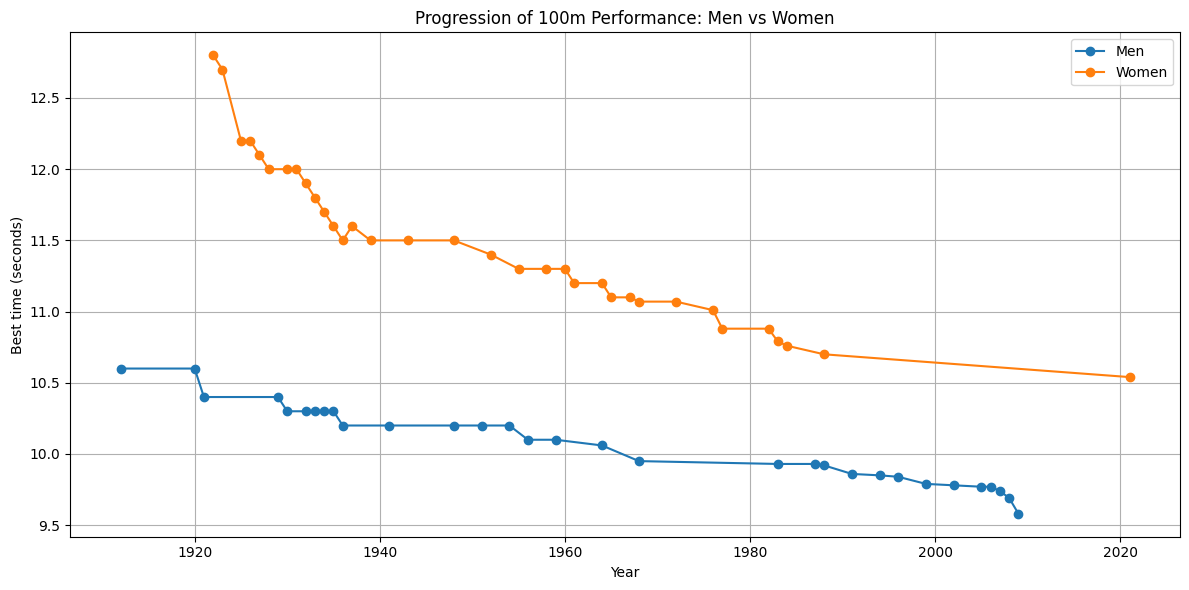

In [12]:

# Compute yearly best time (minimum) for each sex
yearly_best = (
    df.groupby(["sex", "year"])["time_seconds"]
      .min()
      .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
for sex, group in yearly_best.groupby("sex"):
    plt.plot(group["year"], group["time_seconds"], marker="o", label=sex.capitalize())

plt.title("Progression of 100m Performance: Men vs Women")
plt.xlabel("Year")
plt.ylabel("Best time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




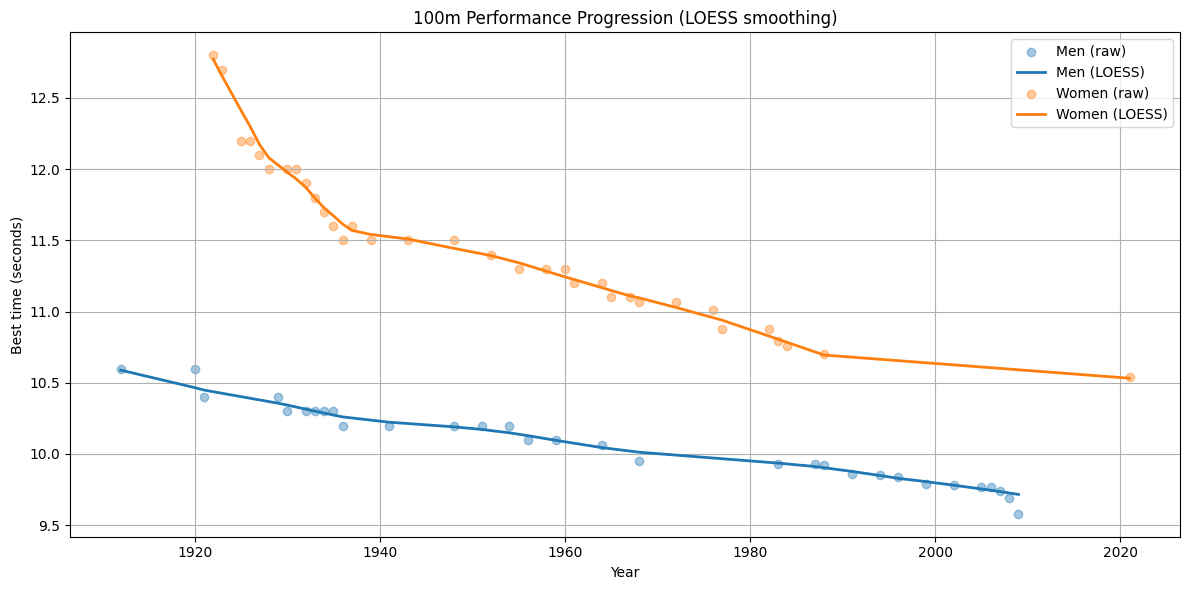

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

### LOESS smoothing (men vs women)

plt.figure(figsize=(12, 6))

for sex, group in yearly_best.groupby("sex"):
    group = group.sort_values("year")

    # Raw points
    plt.scatter(group["year"], group["time_seconds"], alpha=0.4, label=f"{sex.capitalize()} (raw)")

    # LOESS smoothing
    smoothed = lowess(
        endog=group["time_seconds"],
        exog=group["year"],
        frac=0.3  # smoothing parameter (0.2–0.4 usually looks good)
    )
    plt.plot(smoothed[:, 0], smoothed[:, 1], linewidth=2, label=f"{sex.capitalize()} (LOESS)")

plt.title("100m Performance Progression (LOESS smoothing)")
plt.xlabel("Year")
plt.ylabel("Best time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
### Build a continuous yearly series and forward-fill

# Determine the full range of years
start_year = int(yearly_best["year"].min())
end_year = 2025  # current year

years = pd.Index(range(start_year, end_year + 1), name="year")

# Pivot: year as index, one column per sex
pivot = (
    yearly_best
    .pivot(index="year", columns="sex", values="time_seconds")
    .reindex(years)          # ensure all years are present
    .sort_index()
)

# Forward-fill each sex separately: propagate last known record
pivot = pivot.ffill()

display(pivot)


sex,men,women
year,,
1912,10.60,NaN
1913,10.60,NaN
1914,10.60,NaN
1915,10.60,NaN
1916,10.60,NaN
...,...,...
2021,9.58,10.54
2022,9.58,10.54
2023,9.58,10.54


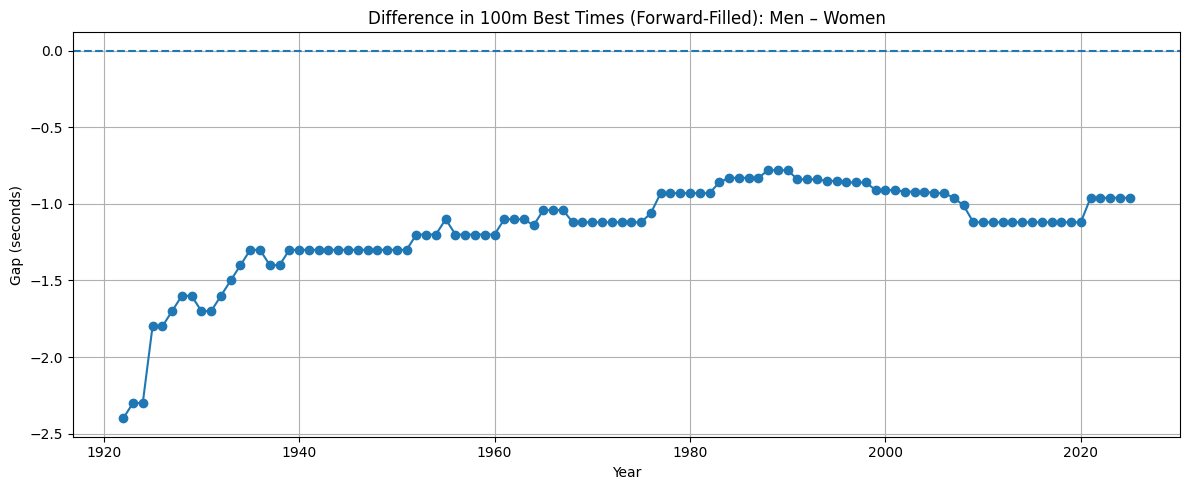

In [ ]:
### Difference curve: men – women (seconds)

# Gap DataFrame between men and women
gap_df = pivot.copy()

# Absolute gap: men - women (only meaningful where women is not NaN)
gap_df["gap_seconds"] = gap_df["men"] - gap_df["women"]

plt.figure(figsize=(12, 5))
plt.plot(gap_df.index, gap_df["gap_seconds"], marker="o")
plt.axhline(0, linestyle="--")
plt.title("Difference in 100m Best Times (Forward-Filled): Men – Women")
plt.xlabel("Year")
plt.ylabel("Gap (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()


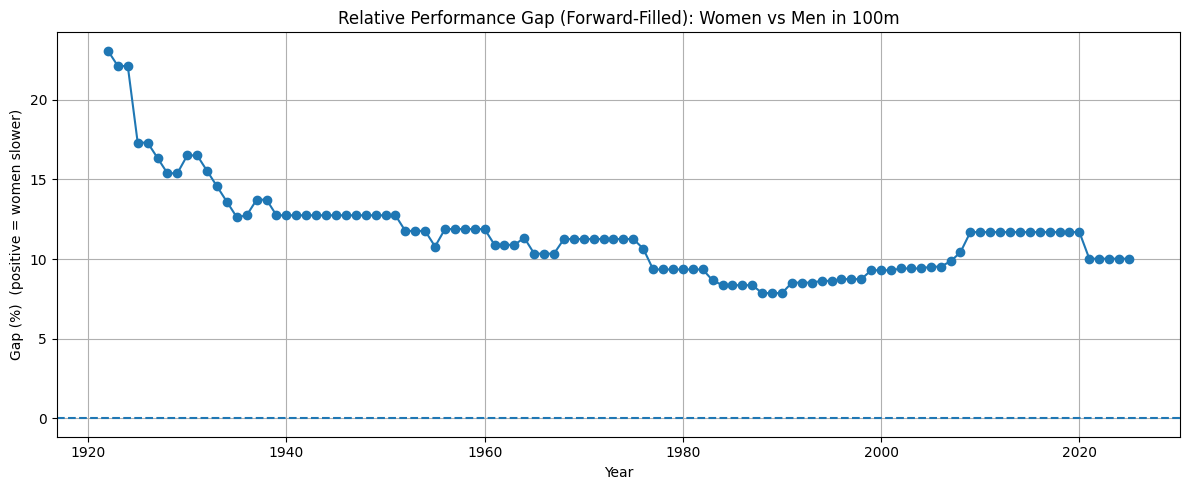

In [26]:
# Relative gap (%): women vs men
gap_df["gap_pct"] = (gap_df["women"] - gap_df["men"]) / gap_df["men"] * 100

plt.figure(figsize=(12, 5))
plt.plot(gap_df.index, gap_df["gap_pct"], marker="o")
plt.axhline(0, linestyle="--")
plt.title("Relative Performance Gap (Forward-Filled): Women vs Men in 100m")
plt.xlabel("Year")
plt.ylabel("Gap (%)  (positive = women slower)")
plt.grid(True)
plt.tight_layout()
plt.show()


Men slope: -0.0083 seconds per year
Women slope: -0.0213 seconds per year


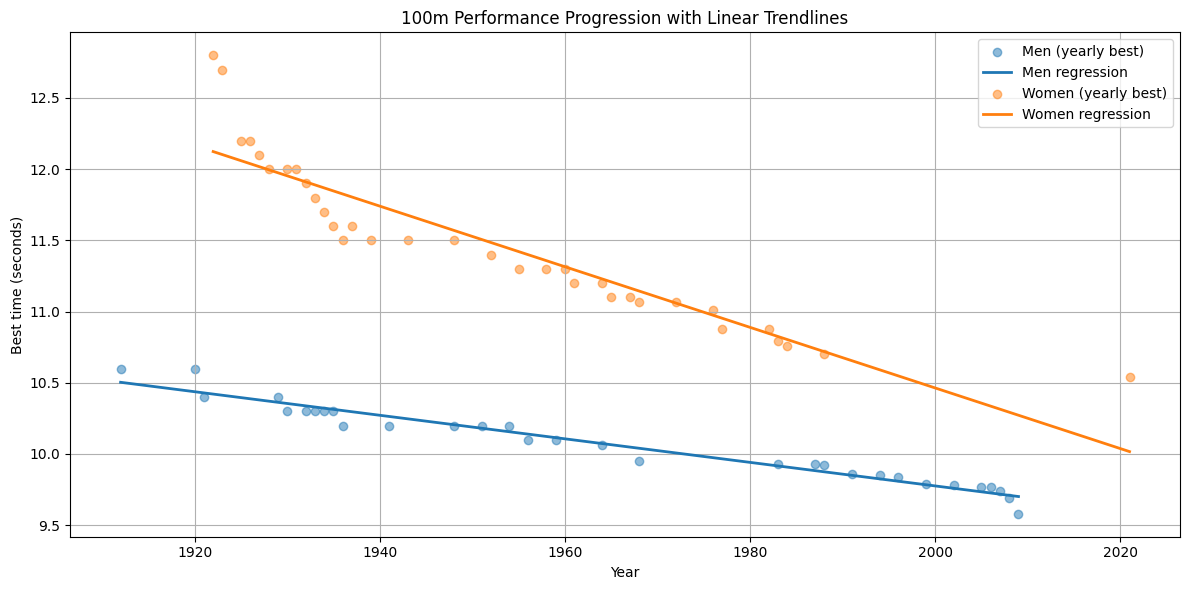

In [17]:
### Regression slopes (how fast each sex improves)

import numpy as np

plt.figure(figsize=(12, 6))

for sex, group in yearly_best.groupby("sex"):
    group = group.sort_values("year")

    x = group["year"].values
    y = group["time_seconds"].values

    # Scatter of yearly best
    plt.scatter(x, y, alpha=0.5, label=f"{sex.capitalize()} (yearly best)")

    # Linear regression using numpy
    coef = np.polyfit(x, y, 1)  # coef[0] = slope, coef[1] = intercept
    slope, intercept = coef

    # Predicted line
    y_pred = slope * x + intercept
    plt.plot(x, y_pred, linewidth=2, label=f"{sex.capitalize()} regression")

    # Print slope info
    print(f"{sex.capitalize()} slope: {slope:.4f} seconds per year")

plt.title("100m Performance Progression with Linear Trendlines")
plt.xlabel("Year")
plt.ylabel("Best time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Men regression slope: -0.00875 seconds/year
Women regression slope: -0.01570 seconds/year


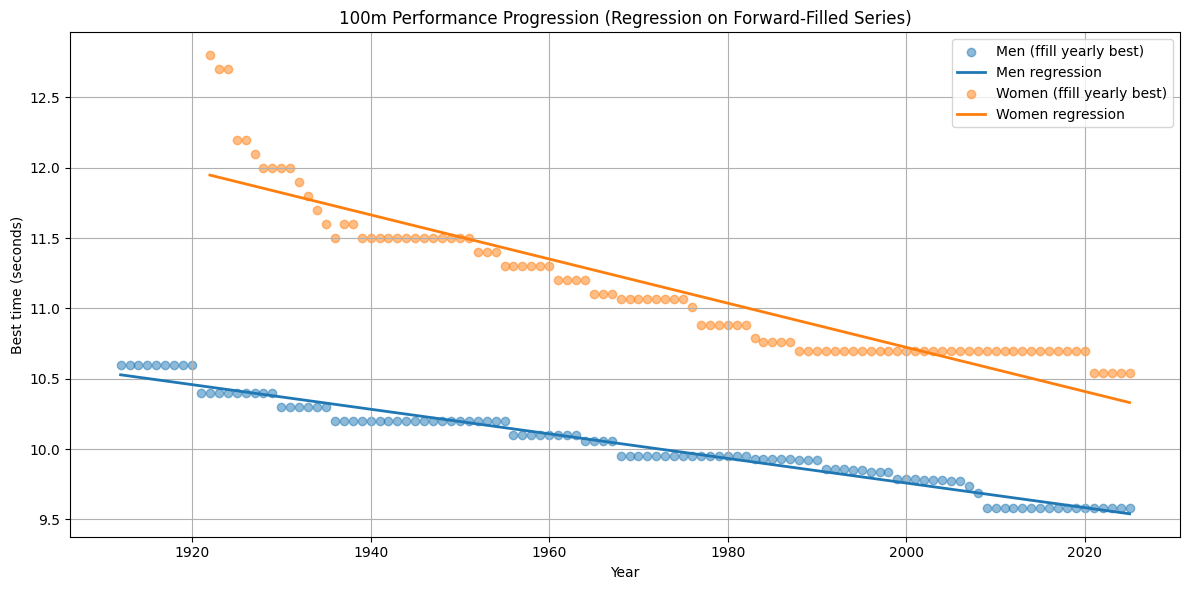

In [31]:
### Regression slopes on forward-filled series

plt.figure(figsize=(12, 6))

for sex in ["men", "women"]:
    # Extract the yearly series
    series = gap_df[sex].dropna()  # women may have NaN early on
    x = series.index.values
    y = series.values

    # Scatter of the forward-filled series
    plt.scatter(x, y, alpha=0.5, label=f"{sex.capitalize()} (ffill yearly best)")

    # Linear regression
    slope, intercept = np.polyfit(x, y, 1)
    y_pred = slope * x + intercept

    # Plot regression line
    plt.plot(x, y_pred, linewidth=2, label=f"{sex.capitalize()} regression")

    # Print slope result
    print(f"{sex.capitalize()} regression slope: {slope:.5f} seconds/year")

plt.title("100m Performance Progression (Regression on Forward-Filled Series)")
plt.xlabel("Year")
plt.ylabel("Best time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

